<h1 align=center><font size = 5>Identifying Potential Locations for Pre-School and After-School Care - New York City</font></h1>

## Introduction

#### In this Capstone Project, I will utilize New York City Geo Data, Population Projection and venues data from Foursquare API and apply *k*-means clustering algorithm to identify neighborhoods that would provide a market for starting a new Pre-School and After-School Child Care Center.

#### We begin by downloading and importing relevant libraries and packages that will be used throughout this analysis.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

<a id='item1'></a>
## 1. Download and Explore Dataset

#### Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

#### This dataset exists for free on the web and is hosted at: https://geo.nyu.edu/catalog/nyu_2451_34572

#### The data is downloaded and placed on an IBM box. We will run 'wget' command to download the data.

In [2]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#### All the relevant data (list of neighborhoods) is in the *features* key.

In [4]:
neighborhoods_data = newyork_data['features']

#### Let's take a look at the first item in this list.

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transforming this data of nested Python dictionaries into a *pandas* dataframe. Start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#### Looping through the data and fill the dataframe one row at a time.

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#### Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


**Load New York Population Projection Data**

#### Next step is to load the population projection data to understand how the target population (0-9 year old) is projected to grow in all boroughs. For this, we will use the *Projected_Population_2010-2040_-_Total_By_Age_Groups* dataset which is hosted by https://data.cityofnewyork.us

#### The dataset is downloaded from the website and accessed here.

In [10]:
ny_pop_proj = pd.read_csv(r'/resources/data/Projected_Population_2010-2040_-_Total_By_Age_Groups.csv')
ny_pop_proj.head()

,Borough,Age,2010,2015,2020,2025,2030,2035,2040
0,NYC Total,0-4,521990,535209,545778,547336,542426,540523,546426
1,NYC Total,15-19,539844,505783,492532,519298,535024,546062,546750
2,NYC Total,20-24,647483,646075,606203,591683,625253,643728,657403
3,NYC Total,25-29,736105,770396,763956,715824,698195,740437,762757
4,NYC Total,30-34,667657,707726,743916,740268,693684,675497,715486


#### As we are interested in population projections for individual boroughs, we can delete historical year columns and 'NYC Total' rows.
#### Also, since our target age group is 0-9 years, we delete other age-groups from the dataset.

In [11]:
ny_pop_proj.drop(['2010', '2015'], axis = 1, inplace = True)
ny_pop_proj = ny_pop_proj[ny_pop_proj['Borough'] != 'NYC Total']
age_filter = ['0-4', '5-9']
ny_pop_proj = ny_pop_proj[ny_pop_proj['Age'].isin(age_filter)].sort_values(['Borough', 'Age']).reset_index(drop = True)
ny_pop_proj

,Borough,Age,2020,2025,2030,2035,2040
0,Bronx,0-4,109972,111127,110880,110982,112571
1,Bronx,5-9,105775,109843,111137,110893,110942
2,Brooklyn,0-4,186886,184273,182152,182974,186465
3,Brooklyn,5-9,180252,182013,179508,177289,178081
4,Manhattan,0-4,82096,83225,80452,77272,76687
5,Manhattan,5-9,68243,72011,72942,69971,66801
6,Queens,0-4,138141,139574,139958,140733,142459
7,Queens,5-9,132342,133933,135413,135764,136512
8,Staten Island,0-4,28683,29137,28984,28562,28244
9,Staten Island,5-9,29394,29890,30397,30253,29816


#### Now we will plot the population projections for each boroughs to get an understanding of the trend

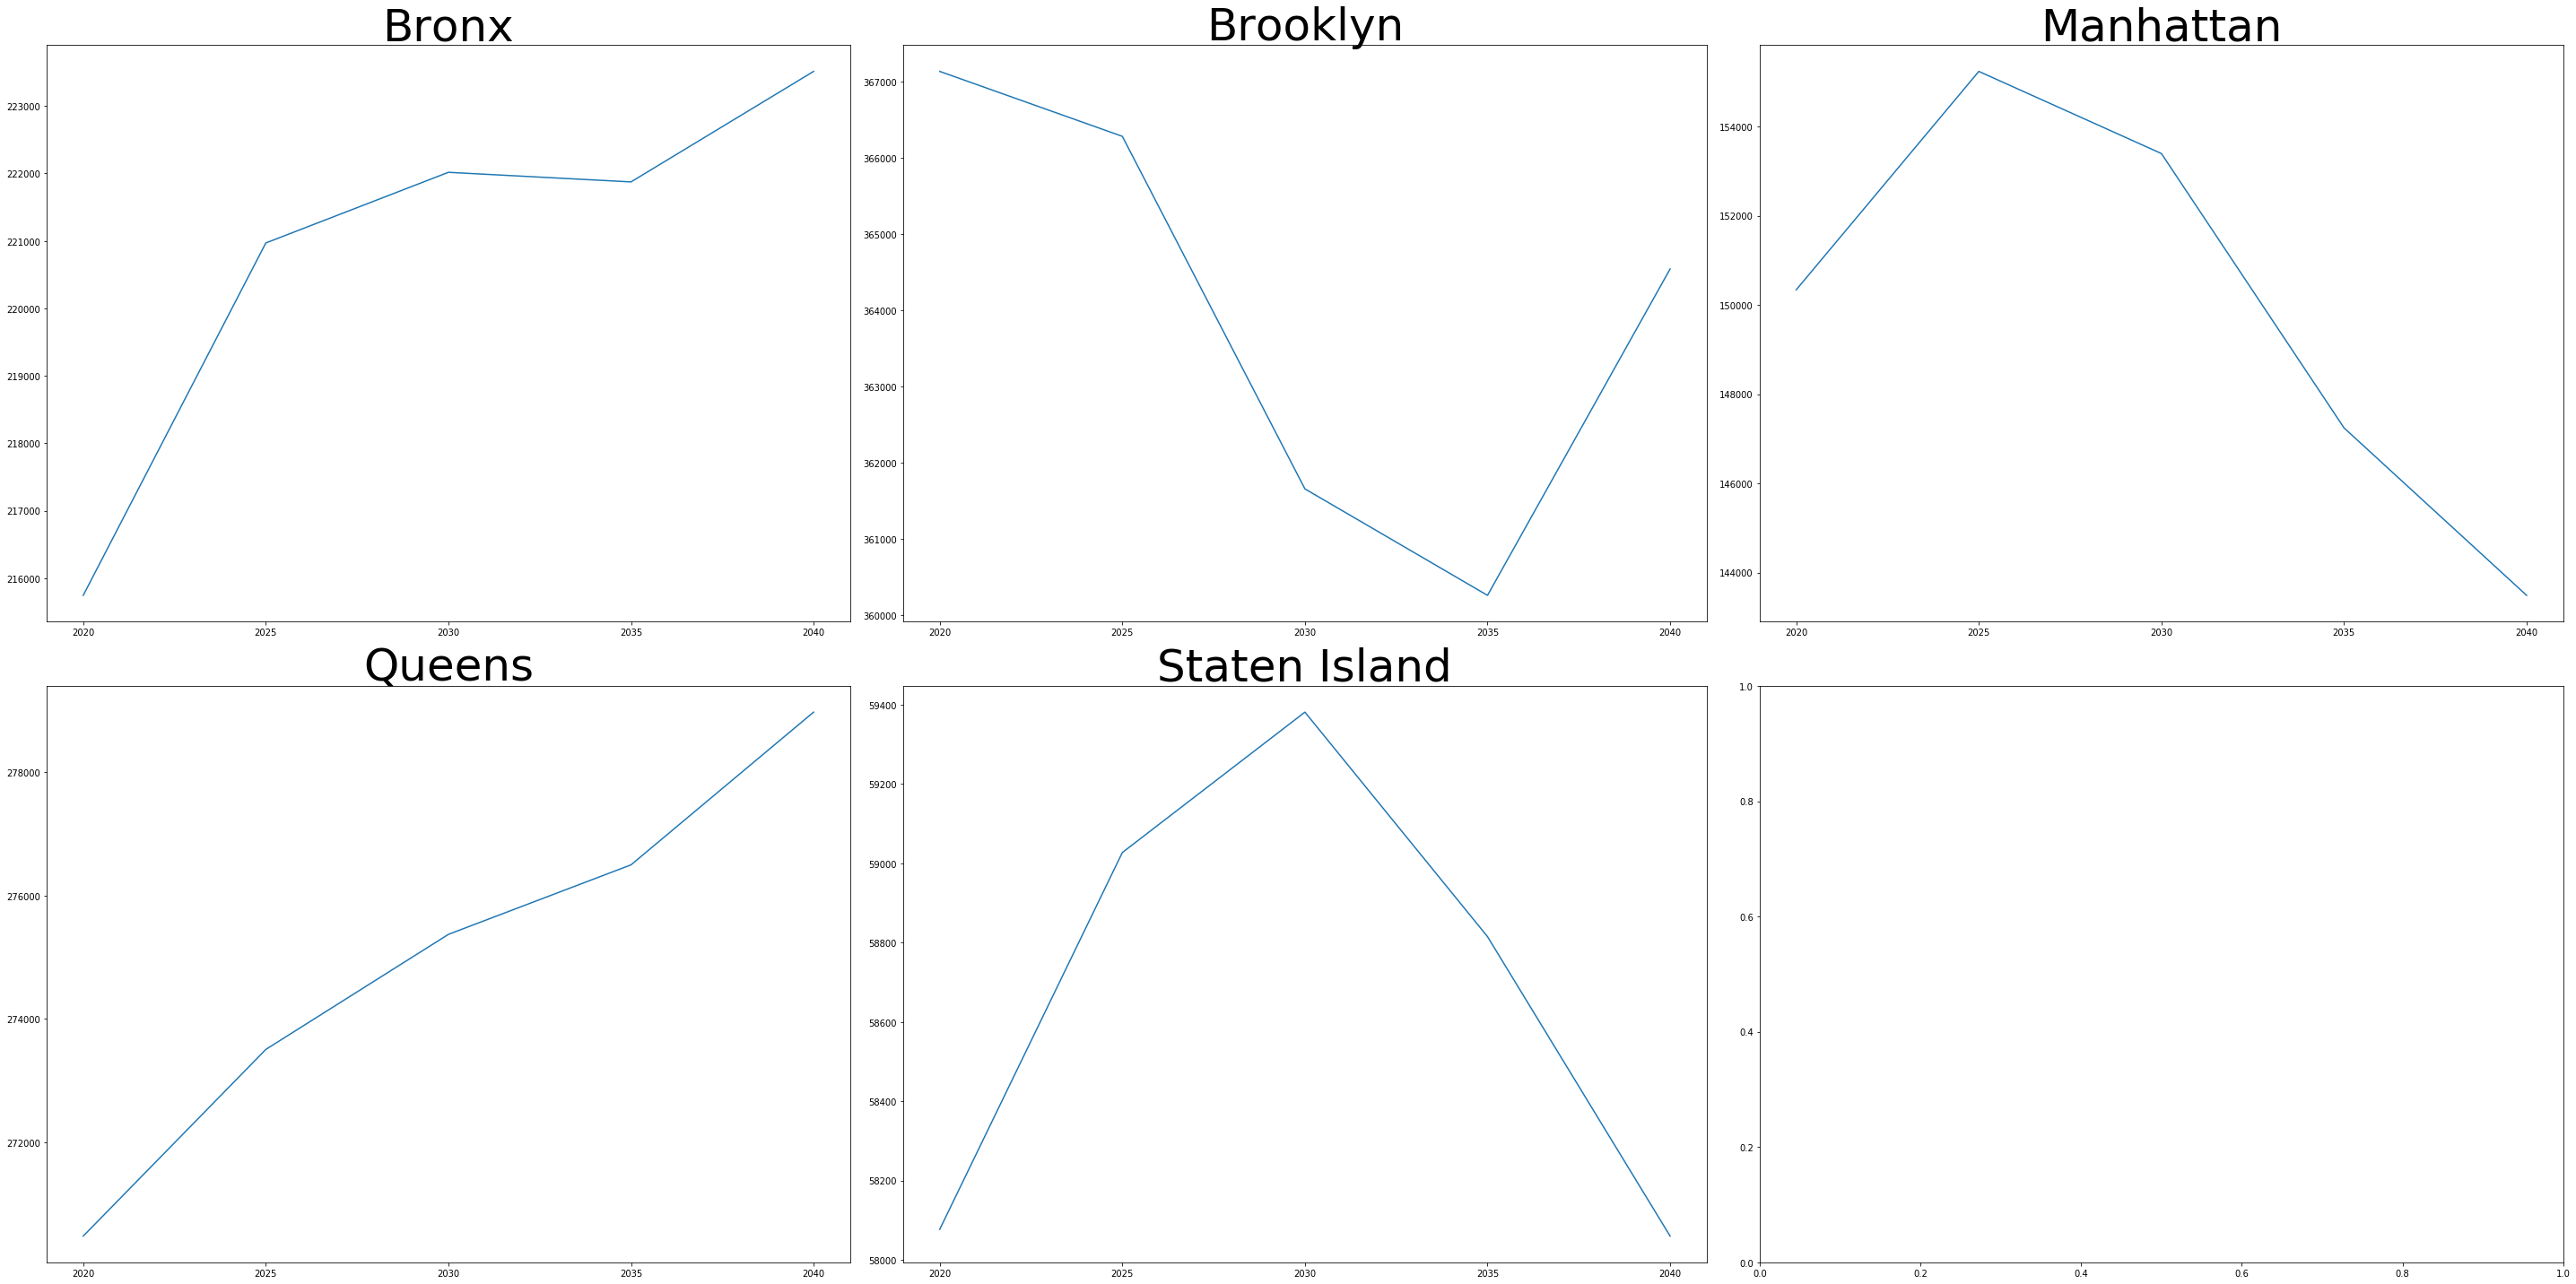

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(40, 20))
titles = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
year = ['2020', '2025', '2030', '2035', '2040']
ny_pop_grouped = ny_pop_proj.groupby('Borough').sum()
#ny_pop_grouped.reset_index(inplace = True)
ny_pop_list = ny_pop_grouped.values.tolist()

for ax, title, list in zip(axes.flat, titles, ny_pop_list):
    ax.plot(year, list)
    ax.set_title(title, fontsize = 50)
    ax.grid = True
plt.tight_layout()
plt.show()


#### Looking at the charts, we can infer that our target demographic (kids under 9 years old) is projected to **increase** in '**Bronx**' and '**Queens**' and **decrease** in '**Brooklyn**', '**Manhattan'** and '**Staten Island**' over the course of next 20 years.

#### Since the analysis is to identify potential market for a new pre-school and after school care center, we should focus on boroughs where our target demographic is projected to grow.
#### So we will focus our analysis on the boroughs of '**Bronx**' and '**Queens**'.

In [13]:
borough_filter = ['Bronx', 'Queens']

BxQn_data = neighborhoods[neighborhoods['Borough'].isin(borough_filter)].reset_index(drop = True)

BxQn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
address = 'LaGuardia Airport, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of LaGuardia Airport are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of LaGuardia Airport are 40.7757145, -73.8733639851154.


#### Let's visualize the LaGuardia Airport the neighborhoods.

In [15]:
map_LaGuardia = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(BxQn_data['Latitude'], BxQn_data['Longitude'], BxQn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LaGuardia)  
    
map_LaGuardia

#### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Let's explore the first neighborhood in our dataframe.

#### Get the neighborhood's latitude and longitude values.

In [17]:
address = 'Bronx, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bronx are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Bronx are 40.85048545, -73.8404035580209.


In [18]:
neighborhood_latitude = latitude 
neighborhood_longitude = longitude

neighborhood_name = address

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bronx, NY are 40.85048545, -73.8404035580209.


In [19]:
# type your answer here
query = 'preschool'
intent = 'browse'
radius = 2500
LIMIT = 50
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&intent={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, query, intent, radius, LIMIT)

#### Send the GET request and examine the resutls

In [20]:
results = requests.get(url).json()
results['response']['venues'][0]


{'id': '50f8382ee4b0e5b3e85438c4',
 'name': 'The Lifeskills Preschool',
 'location': {'address': '3051 E Tremont Ave',
  'lat': 40.8636024402731,
  'lng': -73.8340809301848,
  'labeledLatLngs': [{'label': 'display',
    'lat': 40.8636024402731,
    'lng': -73.8340809301848}],
  'distance': 1554,
  'postalCode': '10461',
  'cc': 'US',
  'city': 'Bronx',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['3051 E Tremont Ave',
   'Bronx, NY 10461',
   'United States']},
 'categories': [{'id': '4f4533814b9074f6e4fb0107',
   'name': 'Nursery School',
   'pluralName': 'Nursery Schools',
   'shortName': 'Nursery School',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/school_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1550517276',
 'hasPerk': False}

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Cleaning the json and structure it into a *pandas* dataframe.

In [22]:
venues = results['response']['venues']#[0]['name']
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head(2)

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '4f4533814b9074f6e4fb0107', 'name': 'N...",False,50f8382ee4b0e5b3e85438c4,3051 E Tremont Ave,US,Bronx,United States,1554,"[3051 E Tremont Ave, Bronx, NY 10461, United S...","[{'label': 'display', 'lat': 40.8636024402731,...",40.863602,-73.834081,10461,NY,The Lifeskills Preschool,v-1550517276
1,"[{'id': '4bf58dd8d48988d13b941735', 'name': 'S...",False,4ec142bab803bca7dee255ee,1881 Bronxdale Ave,US,Bronx,United States,1751,"[1881 Bronxdale Ave, Bronx, NY 10462, United S...","[{'label': 'display', 'lat': 40.84844021808377...",40.848440,-73.861028,10462,NY,Shining Stars Preschool,v-1550517276


In [23]:
venues = results['response']['venues']    
nearby_venues = json_normalize(venues)

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng,categories
0,The Lifeskills Preschool,"[{'id': '4f4533814b9074f6e4fb0107', 'name': 'N...",40.863602,-73.834081,Nursery School
1,Shining Stars Preschool,"[{'id': '4bf58dd8d48988d13b941735', 'name': 'S...",40.848440,-73.861028,School


## 2. Explore Neighborhoods in Bronx and Queens

In [24]:
BxQn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Function to repeat the same process to all the neighborhoods in Bronx and Queens

In [25]:
def getNearbyVenues(query, names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    query = query
    intent = 'browse'
    radius = radius
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&intent={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            query,
            intent,
            radius, 
            LIMIT)
        
        
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
       
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                '', 
                '', 
                ''  
                '') for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues
    print('Query Completed')
    return(nearby_venues)

#### Now we get the preschools for each neighborhood in Bronx and Queens

In [26]:
BxQn_Preschools = getNearbyVenues(query = 'preschool', names= BxQn_data['Neighborhood'],
                                   latitudes= BxQn_data['Latitude'],
                                   longitudes= BxQn_data['Longitude']
                                  )

Query Completed


#### Let's check the size of the resulting dataframe

In [27]:
print(BxQn_Preschools.shape)
BxQn_Preschools.head()

(431, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Anna's Group Family Daycare and Preschool,40.8875,-73.8507,Daycare
1,Co-op City,40.874294,-73.829939,The Lifeskills Preschool,40.8636,-73.8341,Nursery School
2,Co-op City,40.874294,-73.829939,Anna's Group Family Daycare and Preschool,40.8875,-73.8507,Daycare
3,Eastchester,40.887556,-73.827806,Anna's Group Family Daycare and Preschool,40.8875,-73.8507,Daycare
4,Fieldston,40.895437,-73.905643,BedRock Preschool,40.8849,-73.9122,School


#### When considering opening a pre-school or child care facility, it would be ideal to locate on near a park that will allow the children to get some play time outside of the enclosed four walls. 

#### So in order to know the parks in the neighborhood, we query Foursquare for parks in each neighborhood in Bronx and Queens

In [28]:
BxQn_Park = getNearbyVenues(query = 'Park', names= BxQn_data['Neighborhood'],
                                latitudes= BxQn_data['Latitude'],
                                longitudes= BxQn_data['Longitude'],
                                radius = 1000  
                                  )

Query Completed


#### Now append the Park dataframe to the Preschool dataframe

In [29]:
BxQn_Data = BxQn_Preschools.append(BxQn_Park, ignore_index=True)

In [30]:
print('There are {} uniques categories.'.format(len(BxQn_Data['Venue Category'].unique())))
BxQn_Data['Venue Category'].unique()

There are 150 uniques categories.


array(['Daycare', 'Nursery School', 'School', 'University', None,
       'Preschool', 'Science Museum', 'General Entertainment',
       'General College & University', 'Child Care Service',
       'College Classroom', 'Nightlife Spot', 'Elementary School',
       'Playground', 'Park', 'Pool', 'Medical Center', "Doctor's Office",
       'Bridge', 'Parking', 'Bus Station', 'Basketball Court',
       'State / Provincial Park', 'Baseball Field', 'Pharmacy',
       'Pizza Place', 'Residential Building (Apartment / Condo)',
       'Farmers Market', 'Bagel Shop', 'Rental Car Location',
       'Skate Park', 'Real Estate Office', 'Auto Garage',
       'General Travel', 'Dog Run', 'Food', 'Performing Arts Venue',
       'Food Truck', 'Convention Center', 'Voting Booth', 'Trail',
       'Other Great Outdoors', 'Office', 'Neighborhood',
       "Dentist's Office", 'Recycling Facility', 'Miscellaneous Shop',
       'Plaza', 'Department Store', 'Building', 'Gym', 'Metro Station',
       'Athletics & 

## 3. Analyze Each Neighborhood

In [31]:
# one hot encoding
BxQn_Data_onehot = pd.get_dummies(BxQn_Data[['Venue Category']], prefix="", prefix_sep="")

column_list = BxQn_Data_onehot.columns.tolist()

BxQn_Data_onehot['Neighborhood'] = BxQn_Data['Neighborhood'] 
BxQn_Data_onehot = BxQn_Data_onehot[column_list]
BxQn_Data_onehot.head()

,Antique Shop,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Boat or Ferry,Bridge,Building,Bus Line,Bus Station,Bus Stop,Business Center,Butcher,Café,Campground,Child Care Service,Chiropractor,Church,City,Clothing Store,College & University,College Classroom,College Quad,College Rec Center,College Track,Convention Center,Cycle Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Diner,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Elementary School,Farmers Market,Fast Food Restaurant,Field,Fire Station,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food Truck,Funeral Home,Garden,Gas Station,General College & University,General Entertainment,General Travel,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,High School,Historic Site,Hockey Rink,Home Service,Hospital,Housing Development,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean Restaurant,Lake,Laundromat,Laundry Service,Lawyer,Library,Liquor Store,Locksmith,Medical Center,Memorial Site,Men's Store,Metro Station,Middle School,Miscellaneous Shop,Motel,Moving Target,Multiplex,Nail Salon,National Park,Neighborhood,Nightlife Spot,Non-Profit,Nursery School,Office,Other Great Outdoors,Outlet Store,Park,Parking,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Preschool,Professional & Other Places,Public Art,Racetrack,Real Estate Office,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Shopping Mall,Skate Park,Smoke Shop,Soccer Field,State / Provincial Park,Storage Facility,Student Center,Tanning Salon,Tattoo Parlor,Taxi Stand,Tennis Court,Track,Trail,Train,University,Urgent Care Center,Veterinarian,Voting Booth,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Co-op City,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fieldston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [32]:
BxQn_Data_onehot.shape

(2953, 149)

#### Create filter for categories that are of interest for this analysis (PreSchools and Parks)

In [33]:
category_filter = ['Daycare', 'Nursery School', 'Preschool', 'Child Care Service', 'Elementary School', 'Park', 'State / Provincial Park', 'Playground']

In [34]:
final_columns = []
final_columns = ['Neighborhood'] + category_filter
BxQn_PreSchool_Park = BxQn_Data_onehot[final_columns]

In [35]:
BxQn_PreSchool_Park.head()

,Neighborhood,Daycare,Nursery School,Preschool,Child Care Service,Elementary School,Park,State / Provincial Park,Playground
0,Wakefield,1,0,0,0,0,0,0,0
1,Co-op City,0,1,0,0,0,0,0,0
2,Co-op City,1,0,0,0,0,0,0,0
3,Eastchester,1,0,0,0,0,0,0,0
4,Fieldston,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [36]:
BxQn_grouped = BxQn_PreSchool_Park.groupby('Neighborhood').sum().reset_index()
BxQn_grouped['PreSchool Total'] = BxQn_grouped[['Daycare', 'Nursery School', 'Preschool', 'Child Care Service', 'Elementary School']].sum(axis=1)
BxQn_grouped['Park Total'] = BxQn_grouped[['Park', 'State / Provincial Park', 'Playground']].sum(axis=1)
BxQn_grouped.head()

,Neighborhood,Daycare,Nursery School,Preschool,Child Care Service,Elementary School,Park,State / Provincial Park,Playground,PreSchool Total,Park Total
0,Allerton,1,1,0,0,0,0,0,0,2,0
1,Arverne,0,0,0,0,0,0,0,0,0,0
2,Astoria,1,0,0,0,0,0,0,0,1,0
3,Astoria Heights,1,0,0,0,0,0,0,0,1,0
4,Auburndale,1,1,1,0,0,0,0,0,3,0


## 4. Cluster Neighborhoods

#### Using the *Elbow* method, we identify the best K for *k-means* clustering

In [37]:
BxQn_grouped_clustering = BxQn_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1, 20)
for n_cluster in K :
    kmeans = KMeans(n_clusters=n_cluster).fit(BxQn_grouped_clustering)
    label = kmeans.labels_   
    Sum_of_squared_distances.append(kmeans.inertia_)

<a id='item4'></a>

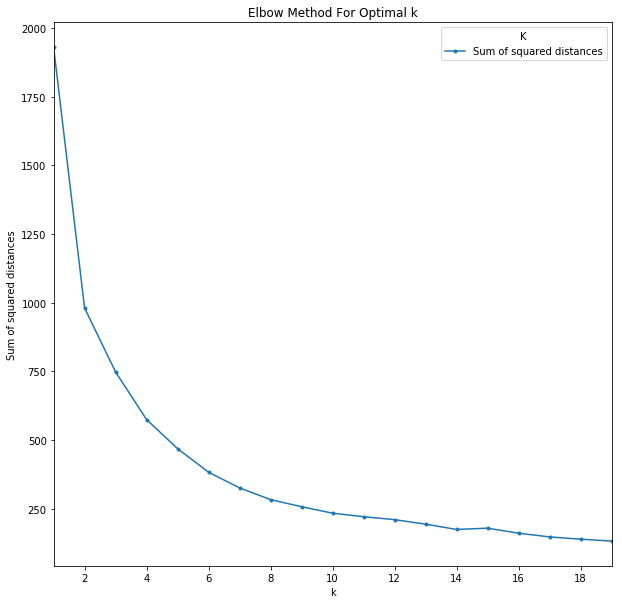

In [38]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum of squared distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
optimal_k.plot(kind = 'line', figsize = (10, 10), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Run *k*-means to cluster the neighborhood into 5 clusters.

In [39]:
# set number of clusters
kclusters = 5

BxQn_grouped_clustering = BxQn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BxQn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 3, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3,
       3, 3, 1, 4, 3, 1, 3, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 2,
       1, 1, 1, 0, 3, 1, 1, 1, 0, 3, 1, 1, 4, 3, 1, 2, 2, 2, 1, 0, 1, 2,
       1, 1, 1, 2, 1, 2, 4, 1, 2, 3, 4, 3, 2, 2, 3, 4, 2, 1, 1, 3, 1, 2,
       3, 2, 4, 2, 3, 1, 4, 1, 1, 2, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1, 1, 3,
       1, 4, 4, 1, 3, 1, 1, 1, 1, 2, 3, 1, 3, 0, 4, 3, 2, 3, 1, 2, 3, 2,
       1], dtype=int32)

In [40]:
BxQn_results = pd.DataFrame(kmeans.cluster_centers_)
BxQn_results.columns = BxQn_grouped_clustering.columns
BxQn_results

,Daycare,Nursery School,Preschool,Child Care Service,Elementary School,Park,State / Provincial Park,Playground,PreSchool Total,Park Total
0,1.500000,1.500000,2.250000,0.000000,0.250000,2.000000,0.000000e+00,2.750000,5.500000,4.750000
1,0.135593,0.118644,0.050847,0.016949,0.000000,0.084746,3.122502e-17,0.016949,0.322034,0.101695
2,1.266667,1.033333,0.833333,0.000000,0.033333,0.033333,1.040834e-17,0.033333,3.166667,0.066667
3,0.300000,0.400000,0.133333,0.000000,0.033333,2.233333,3.333333e-02,1.033333,0.866667,3.300000
4,0.400000,0.400000,0.300000,0.100000,0.100000,5.000000,2.000000e-01,2.900000,1.300000,8.100000


#### From the above result, we can select the clusters that fit our requirement the best.

#### Our goal is to find location suitable for opening a pre-school/daycare facility. So the best neighborhoods would be the ones that have a low score on *Preschool Total*. 
#### Also, we want to have a location with access to parks. So we are looking for a high score on *Park Total*

#### Cluster 3 is the best cluster to meet these criterion and Cluster 4 is second best. The recommendation would be to explore the neighborhoods in these clusters.

In [41]:
BxQn_results_merged = pd.DataFrame(BxQn_grouped['Neighborhood'],)

BxQn_results_merged['PreSchool Total'] = BxQn_grouped['PreSchool Total']
BxQn_results_merged['Park Total'] = BxQn_grouped['Park Total']
BxQn_results_merged = BxQn_results_merged.assign(Cluster_Labels = kmeans.labels_)

In [42]:
print(BxQn_results_merged.shape)
BxQn_results_merged.head()

(133, 4)


,Neighborhood,PreSchool Total,Park Total,Cluster_Labels
0,Allerton,2,0,2
1,Arverne,0,0,1
2,Astoria,1,0,1
3,Astoria Heights,1,0,1
4,Auburndale,3,0,2


In [43]:
BxQn_Merged = BxQn_data

BxQn_Merged = BxQn_Merged.join(BxQn_results_merged.set_index('Neighborhood'), on='Neighborhood')

print(BxQn_Merged.shape)
BxQn_Merged.head()

(133, 7)


,Borough,Neighborhood,Latitude,Longitude,PreSchool Total,Park Total,Cluster_Labels
0,Bronx,Wakefield,40.894705,-73.847201,1,3,3
1,Bronx,Co-op City,40.874294,-73.829939,2,4,3
2,Bronx,Eastchester,40.887556,-73.827806,1,0,1
3,Bronx,Fieldston,40.895437,-73.905643,1,0,1
4,Bronx,Riverdale,40.890834,-73.912585,1,0,1


#### Map of New York City with clusters of interest

#### Map of Cluster 3

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BxQn_Merged['Latitude'], BxQn_Merged['Longitude'], BxQn_Merged['Neighborhood'], BxQn_Merged['Cluster_Labels']):
    if cluster == 3:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


#### Neighborhoods in Cluster 3

In [45]:
BxQn_Merged[BxQn_Merged['Cluster_Labels'] == 3].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,PreSchool Total,Park Total,Cluster_Labels
0,Bronx,Wakefield,40.894705,-73.847201,1,3,3
1,Bronx,Co-op City,40.874294,-73.829939,2,4,3
2,Bronx,City Island,40.847247,-73.786488,0,2,3
3,Bronx,University Heights,40.855727,-73.910416,0,5,3
4,Bronx,Hunts Point,40.809730,-73.883315,1,5,3
5,Bronx,Throgs Neck,40.815109,-73.816350,2,3,3
6,Bronx,Westchester Square,40.840619,-73.842194,1,3,3
7,Bronx,Morris Park,40.847549,-73.850402,1,5,3
8,Bronx,North Riverdale,40.908543,-73.904531,0,3,3
9,Bronx,Schuylerville,40.826580,-73.826203,2,2,3


#### Map of Cluster 4

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BxQn_Merged['Latitude'], BxQn_Merged['Longitude'], BxQn_Merged['Neighborhood'], BxQn_Merged['Cluster_Labels']):
    if cluster == 4:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


#### Neighborhoods in Cluster 4

In [47]:
BxQn_Merged[BxQn_Merged['Cluster_Labels'] == 4].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,PreSchool Total,Park Total,Cluster_Labels
0,Bronx,Morris Heights,40.847898,-73.919672,0,7,4
1,Bronx,Soundview,40.821012,-73.865746,1,8,4
2,Bronx,Clason Point,40.806551,-73.854144,0,6,4
3,Bronx,Parkchester,40.837938,-73.856003,0,11,4
4,Bronx,Van Nest,40.843608,-73.866299,2,10,4
5,Queens,South Jamaica,40.696911,-73.790426,3,6,4
6,Queens,Pomonok,40.734936,-73.804861,3,8,4
7,Bronx,Mount Hope,40.848842,-73.908299,0,7,4
8,Queens,Hunters Point,40.743414,-73.953868,3,11,4
9,Queens,Malba,40.790602,-73.826678,1,7,4


## End of Analysis